In [15]:
import numpy as np
%load_ext autoreload
%autoreload 2

from ctrl.control_system import *

## parameters
mCart = 1  # cart mass
mPend = 1  # pendulum mass
G = 9.81   # gravity of earth
L = 0.5    # pendulum length
Kd = 10    # cart damping

f = lambda x, u: np.array(
        [x[1],
        (u - Kd*x[1] - mPend*L*x[3]**2*np.sin(x[2]) + mPend*G*np.sin(x[2])*np.cos(x[2])) / (mCart + mPend*np.sin(x[2])**2),
        x[3],
        ((u - Kd*x[1] - mPend*L*x[3]**2*np.sin(x[2]))*np.cos(x[2])/(mCart + mPend) + G*np.sin(x[2])) / (L - mPend*L*np.cos(x[2])**2/(mCart + mPend))]
)

g = lambda x, u: np.array([x[0], x[2]])

ct_sys = ContinuousControlSystem(f, g, 4, 1, 2)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


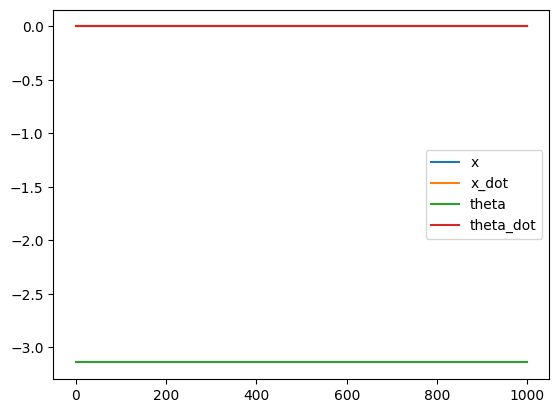

In [16]:
import matplotlib.pyplot as plt


x0 = np.array([0, 0, -np.pi, 0])

t = np.linspace(0, 10, 1000)
x, y = ct_sys.sim(x0, t, 0)
plt.plot(x, label=['x', 'x_dot', 'theta', 'theta_dot'])
plt.legend()

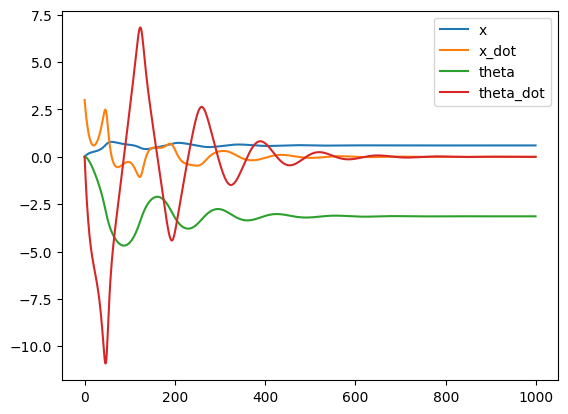

In [17]:
x0 = np.array([0, 3, 0, 0])
ct_x, _ = ct_sys.sim(x0, t, 0)
plt.plot(ct_x, label=['x', 'x_dot', 'theta', 'theta_dot'])
plt.legend()


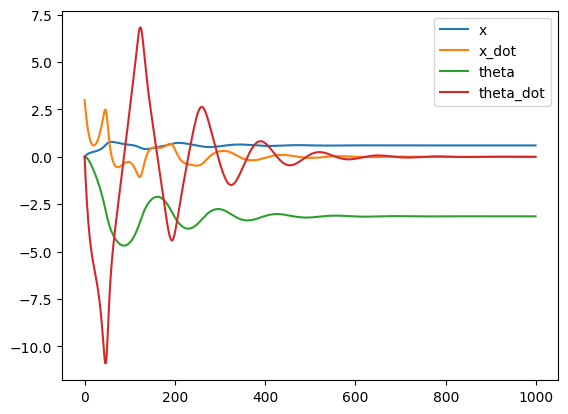

In [4]:
dt_sys = discretize_system(ct_sys, dt=0.01)
dt_x, _ = dt_sys.sim(x0, t, 0)
plt.plot(dt_x, label=['x', 'x_dot', 'theta', 'theta_dot'])
plt.legend()

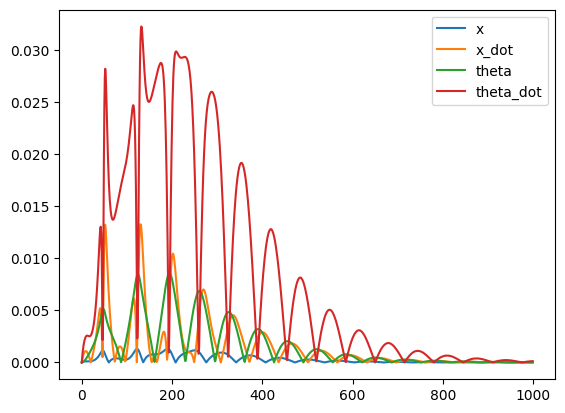

In [5]:
plt.plot(np.abs(dt_x-ct_x), label=['x', 'x_dot', 'theta', 'theta_dot'])
plt.legend()

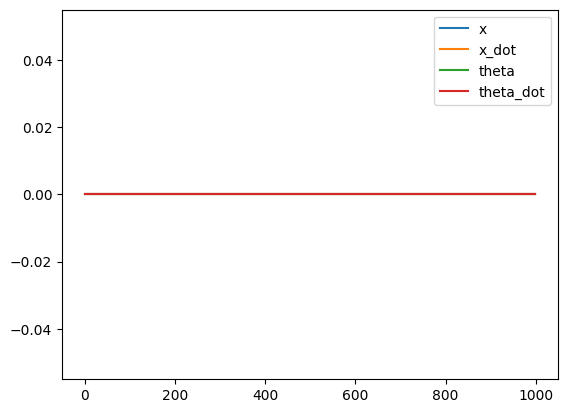

In [6]:
x0 = np.array([0, 0, 0, 0])
lct_sys = linearize_system(ct_sys, x0, 0)

lct_x, _ = lct_sys.sim(x0, t, 0)
plt.plot(lct_x, label=['x', 'x_dot', 'theta', 'theta_dot'])
plt.legend()

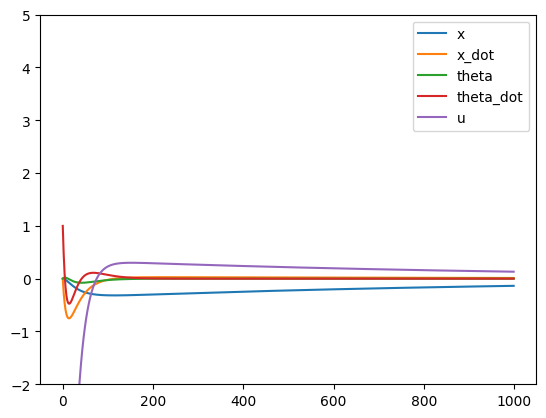

In [7]:
# 1st approach: LQR
# We synthesise a LQR controller using linearized, discrete-time model

from ctrl.mpc.mpc import LQRController

ldt_model = discretize_system(lct_sys, dt=0.01)
lqr = LQRController(ldt_model, Q=np.eye(4), R=np.eye(1))

# We simulate the discrete-time system with the LQR controller
K = lqr.K
ldt_lqr_model = DiscreteLTISystem(ldt_model.A - ldt_model.B @ K, ldt_model.B, ldt_model.C, ldt_model.dt)

x0 = np.array([0, 0, 0, 1])
t = 10
x, _ = ldt_lqr_model.sim(x0, t, 0)

plt.plot(x, label=['x', 'x_dot', 'theta', 'theta_dot'])
plt.plot(-x @ K.T, label='u')
plt.ylim([-2, 5])
plt.legend()

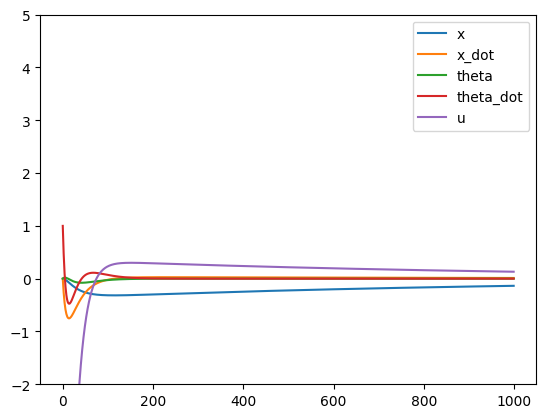

In [8]:
from ctrl.simulation import DiscreteControllerPlantObserverLoop

s = DiscreteControllerPlantObserverLoop(lqr, dt_sys)

x2, x_est, y, u = s.sim(x0, t)

plt.plot(x2, label=['x', 'x_dot', 'theta', 'theta_dot'])
plt.plot(u, label='u')
plt.ylim([-2, 5])
plt.legend()

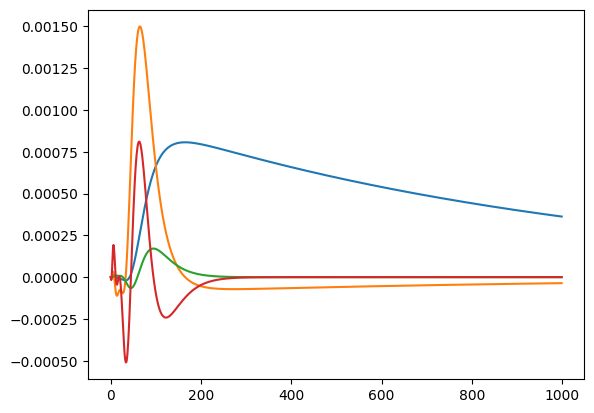

In [9]:
plt.plot(x2-x)

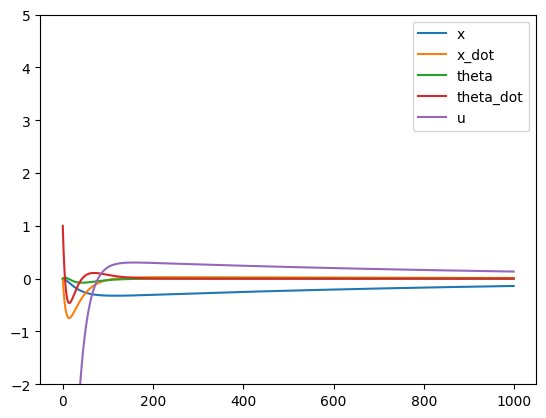

In [13]:
from ctrl.simulation import ContinuousControllerPlantObserverLoop
from ctrl.mpc.mpc import ZeroHoldController

s = ContinuousControllerPlantObserverLoop(ZeroHoldController(lqr, dt_sys.dt), ct_sys)

t = np.linspace(0, 10, 1000)
x2, x_est, y, u = s.sim(x0, t)

plt.plot(x2, label=['x', 'x_dot', 'theta', 'theta_dot'])
plt.plot(u, label='u')
plt.ylim([-2, 5])
plt.legend()
